# SpamHam Classification Using HuggingFace & PyTorch 🚀

In [33]:
import re
import pandas as pd
import numpy as np 

import torch
import torchvision
import torch.nn as nn
from torchtext import data
import torch.optim as optim
from torchvision import transforms

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split as split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, auc, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
raw = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')
raw.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
raw.describe().T

,count,unique,top,freq
v1,5572,2,ham,4825
v2,5572,5169,"Sorry, I'll call later",30
Unnamed: 2,50,43,"bt not his girlfrnd... G o o d n i g h t . . .@""",3
Unnamed: 3,12,10,"MK17 92H. 450Ppw 16""",2
Unnamed: 4,6,5,"GNT:-)""",2


In [7]:
raw.drop(columns=raw.columns[2:], inplace=True)
raw.rename(columns={'v1': 'labels', 'v2': 'texts'}, inplace=True)
raw['labels'] = raw['labels'].map({'spam': 1, 'ham': 0}).astype(np.int64)
raw.sample(10)

,labels,texts
5393,0,"All done, all handed in. Don't know if mega sh..."
1777,1,Buy Space Invaders 4 a chance 2 win orig Arcad...
1773,0,"I'm not coming over, do whatever you want"
1536,0,How's it feel? Mr. Your not my real Valentine ...
4264,0,&lt;DECIMAL&gt; m but its not a common car he...
3343,0,Oh great. I.ll disturb him more so that we can...
2082,0,I'm done oredi...
234,1,Text & meet someone sexy today. U can find a d...
2903,0,HI DARLIN I HOPE YOU HAD A NICE NIGHT I WISH I...
2364,0,Ok then no need to tell me anything i am going...


labels
0    4825
1     747
Name: count, dtype: int64
----------

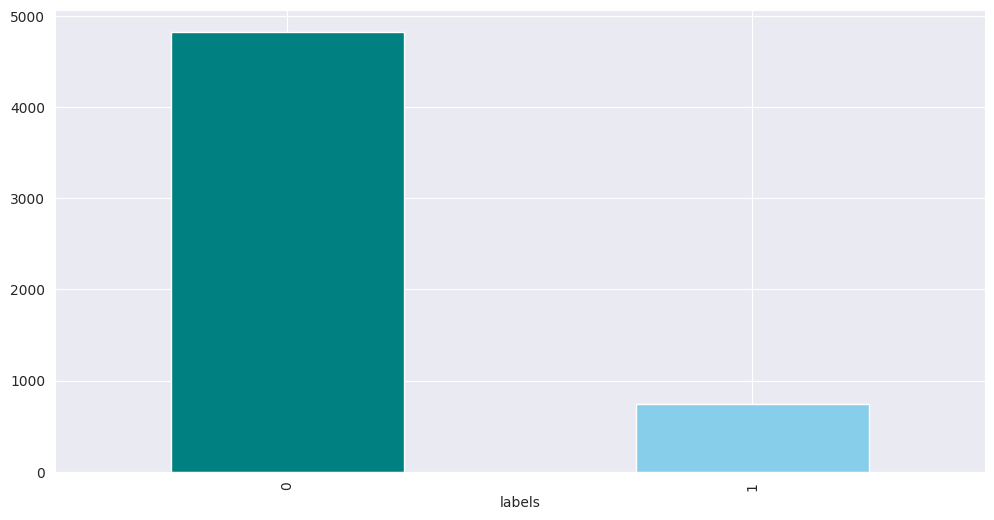

In [8]:
print(raw['labels'].value_counts(), end="\n----------")
raw['labels'].value_counts().plot.bar(color=['teal', 'skyblue'], figsize=(12, 6));

# Lengths of the messages based on the category 📩

- You can see some excepts within the cateogies.
- Balance the unbalanced dataset.

In [9]:
raw['length'] = raw['texts'].apply(len)

raw.describe().T

,count,mean,std,min,25%,50%,75%,max
labels,5572.0,0.134063,0.340751,0.0,0.0,0.0,0.0,1.0
length,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0


In [10]:
raw.head(10)

,labels,texts,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


In [11]:
raw[raw['labels'] == 1]['length'].describe().T

count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: length, dtype: float64

# Text Processing 🏄
- Removal of stop-words
- Removal of punctuations (redundant values)

In [12]:
stoppies = stopwords.words("english")

replacements = {
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "i'll": "i will",
    "you'll": "you will",
    "we'll": "we will",
    "they'll": "they will",
    "he'd": "he would",
    "she'd": "she would",
    "it'd": "it would",
    "i'd": "i would",
    "you'd": "you would",
    "we'd": "we would",
    "they'd": "they would",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "won't": "will not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not",
    "aren't": "are not",
    "isn't": "is not",
    "wasn't": "was not",
    "weren't": "were not",
}

def replacer(text: str) -> str:
    for k, v in replacements.items():
        text = text.replace(k, v).lower()
    return text

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    no_tags = soup.get_text()
    return no_tags

def processing(text: str) -> str:
    text = text.lower() 
    text = re.sub(r"\#","", text)                   # replaces hashtags
    text = re.sub(r"http\S+","URL", text)           # remove URL addresses
    text = re.sub(r"@","", text)
    text = re.sub(r"[^A-Za-z0-9()!?\'\`\"]", " ", text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

In [13]:
raw['clean'] = raw.texts.apply(replacer)
raw['clean'] = raw.clean.apply(lambda x: " ".join(x for x in x.split() if x not in set(stoppies)))
raw['clean'] = raw.clean.apply(remove_html_tags)
raw['clean'] = raw.clean.apply(processing)
raw['clean'] = raw.clean.apply(lambda x: " ".join(x for x in x.split() if len(x) > 1))

In [14]:
raw.clean.sample(20).values

array(['alright set here text man', 'said would woke',
       'might go sch yar salon boring',
       'todays voda numbers ending selected receive award hava match please call quoting claim code standard rates app',
       'konw waht rael friendship im gving yuo exmpel jsut ese tihs msg evrey splleing tihs msg wrnog bt sitll yuo raed wihtuot ayn mitsake goodnight nice sleep sweet dreams',
       'reminder get pounds free call credit details great offers pls reply text valid name house postcode',
       'nd time tried contact pound prize claim easy call now! per min bt national rate',
       'hi customer loyalty offer the new nokia mobile txtauction! txt word start no get now! ctxt tc mtmsg',
       'big difference versus every hrs', 'sorry uncle ll keep touch',
       "dear xxxxxxx u've invited xchat final attempt contact u! txt chat msgrcvdhg suite lands row wjhl ldn yrs",
       'pls ask macho much budget bb bold cos saw new one dollars',
       'today iz yellow rose day love frndshi

# Model Building 🔮

**Tokenize the textual data**

In [15]:
texts = raw.clean.values.tolist()
labels = raw.labels.values.tolist()

train_inp, test_inp, train_target, test_target = split(texts, labels, test_size=.20, stratify=labels, random_state=42)

In [16]:
%%capture
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_inp, truncation=True, padding='max_length', return_tensors='pt', max_length=300)
test_encodings = tokenizer(test_inp, truncation=True, padding='max_length', return_tensors='pt', max_length=300)

In [17]:
%%capture
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=5e-5)
loss_func = nn.CrossEntropyLoss()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Convert tokenized data and labels into PyTorch datasets** 🪫

In [20]:
BATCH_SIZE = 32

# Tokenized data into a pytorch dataset.
train_dataset = torch.utils.data.TensorDataset(
    train_encodings.input_ids, train_encodings.attention_mask, torch.tensor(train_target))
test_dataset  = torch.utils.data.TensorDataset(
    test_encodings.input_ids, test_encodings.attention_mask, torch.tensor(test_target))

# Prepare DataLoader for efficient batch training
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_loader  = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

# Model Training 🚀

In [28]:
def train(model: any, dataloader: torch.utils.data.DataLoader, optimizer: callable, loss_func: callable) -> None:
    model.train()
    totalloss = 0
    
    for batch in dataloader:
        input_ids, masks, labels = batch
        input_ids, masks, labels = input_ids.cuda(), masks.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = model(input_ids, attention_mask=masks)
        labels = labels.long()
        loss = loss_func(output.logits, labels)
        totalloss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Loss: {loss:>7f}")
    
        

def test(model, dataloader, loss_func) -> None:
    model.eval()
    testloss, correct = 0, 0
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, masks, labels = batch
            input_ids, masks, labels = input_ids.cuda(), masks.cuda(), labels.cuda()
            output = model(input_ids, attention_mask=masks)
            labels = labels.long()
            loss = loss_func(output.logits, labels)
            testloss += loss.item()
            preds = torch.argmax(output.logits, dim=1)
            correct += (preds == labels).type(torch.float).sum().item()
        
    correct /= size
    testloss /= num_batches
    
    print(f"Test Error: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {testloss:>8f} \n")

In [29]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(model, train_loader, optimizer, loss_func)
    test(model, test_loader, loss_func)
    
print("DONE !!!")

Epoch 1
-------------------------------
Loss: 0.025347
Test Error: 
Accuracy: 98.7%, Avg loss: 0.040767 

Epoch 2
-------------------------------
Loss: 0.000440
Test Error: 
Accuracy: 99.2%, Avg loss: 0.057154 

Epoch 3
-------------------------------
Loss: 0.000454
Test Error: 
Accuracy: 98.6%, Avg loss: 0.080706 

Epoch 4
-------------------------------
Loss: 0.007918
Test Error: 
Accuracy: 98.7%, Avg loss: 0.054586 

Epoch 5
-------------------------------
Loss: 0.000089
Test Error: 
Accuracy: 99.1%, Avg loss: 0.057609 

Epoch 6
-------------------------------
Loss: 0.000117
Test Error: 
Accuracy: 99.0%, Avg loss: 0.060670 

Epoch 7
-------------------------------
Loss: 0.000033
Test Error: 
Accuracy: 99.1%, Avg loss: 0.064974 

Epoch 8
-------------------------------
Loss: 0.000081
Test Error: 
Accuracy: 98.5%, Avg loss: 0.075733 

Epoch 9
-------------------------------
Loss: 0.000046
Test Error: 
Accuracy: 98.8%, Avg loss: 0.102767 

Epoch 10
-------------------------------
Loss:

# Model Inference 🚑

In [31]:
# check f1 score
# first make prediction on test data